**SETUP**

In [1]:
import pandas as pd
from numba import jit
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
%matplotlib inline
plt.style.use('seaborn-poster')
from matplotlib import cm
from log_progress import log_progress

# TODO 

- [x] create model xy in python 
- [x] calculate Magnetization 
- [ ] Chi
- [ ] helicity modulus
- [ ] make plots for lattice [8, 16, 32, 64] once again!!!

**XY model** 

In [2]:
class XYmodel:
    """Assume that J = 1"""
    def __init__(self, lattice_size, T):
        self.T = T
        self.size = lattice_size
        self.lattice = self.random_init(lattice_size)
        np.random.seed(42)
    
    def random_init(self, size):
        # (-pi, pi)
        return np.pi * (2 * np.random.rand(size, size) - 1)
    
    @jit(parallel=True)
    def step(self):
        for i in range(self.size):
            for j in range(self.size):
                # choose random spin position
                x = np.random.randint(self.size)
                y = np.random.randint(self.size)
                
                # row major not column major, add some randomness (-pi/4, pi/4)
                random_spin = self.lattice[y][x] + 0.25 * np.pi * (2 * np.random.rand(1) - 1)
                
                # make sure random_spin is in range (-pi, pi)
                if random_spin >= np.pi:
                    random_spin -= 2 * np.pi
                if random_spin < -np.pi:
                    random_spin += 2 * np.pi
                
                # calculate E_new - E
                delta_E = self._compute_E(x, y, spin=random_spin) - self._compute_E(x, y)
            
                # update spin 
                boltz = 0
                if self.T != 0:
                    boltz = np.exp(-delta_E / self.T)
                else:
                    print("Temperature = 0")
    
                if delta_E > 0:
                    if np.random.rand(1) < boltz:
                        self.lattice[y][x] = random_spin
                else:
                    self.lattice[y][x] = random_spin        
    
    def _compute_E(self, x, y, spin=None):
        right_x, left_x, up_y, down_y = self._periodic_boundary(x, y)
        E = 0
        if spin != None:
            # E_new
            E = -(np.cos(spin - self.lattice[up_y][x]) + 
                np.cos(spin - self.lattice[down_y][x]) + 
                np.cos(spin - self.lattice[y][right_x]) + 
                np.cos(spin - self.lattice[y][left_x]))
        else:
            # E_old
            E = -(np.cos(self.lattice[y][x] - self.lattice[up_y][x]) + 
                np.cos(self.lattice[y][x] - self.lattice[down_y][x]) + 
                np.cos(self.lattice[y][x] - self.lattice[y][right_x]) + 
                np.cos(self.lattice[y][x] - self.lattice[y][left_x]))
        return E
    
    def _periodic_boundary(self, x, y):
        # periodic boundary condition
        right_x = x + 1;
        left_x = x - 1;
        up_y = y - 1
        down_y = y + 1  
        if left_x < 0:
            left_x = self.size - 1
        if right_x > self.size - 1:
            right_x = 0
        if up_y < 0:
            up_y = self.size - 1
        if down_y > self.size - 1:
            down_y = 0
        return right_x, left_x, up_y, down_y
    
    def calculate_M(self):
        """
        Calculate magnetization per spin
        """
        M_x = np.sum(np.cos(-self.lattice))
        M_y = np.sum(np.sin(-self.lattice))
        M = np.array([M_x, M_y])
        M = linalg.norm(M) / (self.size ** 2)
        return M
    
    def calculate_Sus(self):
        """
        Calculate magnetic susceptibility per spin
        """
        # TODO: 
        # Sth wrong...
        M_x = np.sum(np.power(np.cos(-self.lattice), 2))
        M_y = np.sum(np.power(np.sin(-self.lattice), 2))
        M2 = np.array([M_x, M_y])
        M2 = linalg.norm(M2) / (self.size ** 2)
        Sus = (1 / self.T) * (M2 - self.calculate_M() ** 2)
        return Sus / (self.size ** 2)
    
    def calculate_Helicity(self):
        # https://arxiv.org/pdf/cond-mat/0304226.pdf
        # https://arxiv.org/pdf/1210.6116.pdf
        # https://arxiv.org/pdf/cond-mat/0502556.pdf
        # https://edoc.hu-berlin.de/bitstream/handle/18452/14664/Korzec.pdf?sequence=1
        """
        Calculate helicity modulus per spin
        Y = < E (per spin) > - size^2 / T * < s^2 >
        """
        # TODO: s is very slow -> as the result I get only energy!
        s = 0
        for j in range(self.size):
            for i in range(self.size):
                s += (np.sin(self.lattice[i][j]-self.lattice[(i-1)%L][j])+
                      np.sin(self.lattice[i][j]-self.lattice[(i+1)%L][j])+
                      np.sin(self.lattice[i][j]-self.lattice[i][(j-1)%L])+
                      np.sin(self.lattice[i][j]-self.lattice[i][(j+1)%L]))
        s = s / (self.size ** 2)
        Y = self.calculate_E() - (self.size ** 2) / self.T * s
        return Y
    
    def calculate_E(self):
        """
        Calculate energy per spin
        """
        E = 0
        for j in range(self.size):
            for i in range(self.size):
                E -= (np.cos(self.lattice[i][j]-self.lattice[(i-1)%L][j])+
                      np.cos(self.lattice[i][j]-self.lattice[(i+1)%L][j])+
                      np.cos(self.lattice[i][j]-self.lattice[i][(j-1)%L])+
                      np.cos(self.lattice[i][j]-self.lattice[i][(j+1)%L]))
        return E * 0.5 / (self.size ** 2)
    

In [3]:
L = 10 # lattice size
xy = XYmodel(L, T=0.8)
for _ in range(500):
    xy.step()

In [5]:
%%timeit
xy.calculate_E()

1.08 ms ± 3.71 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


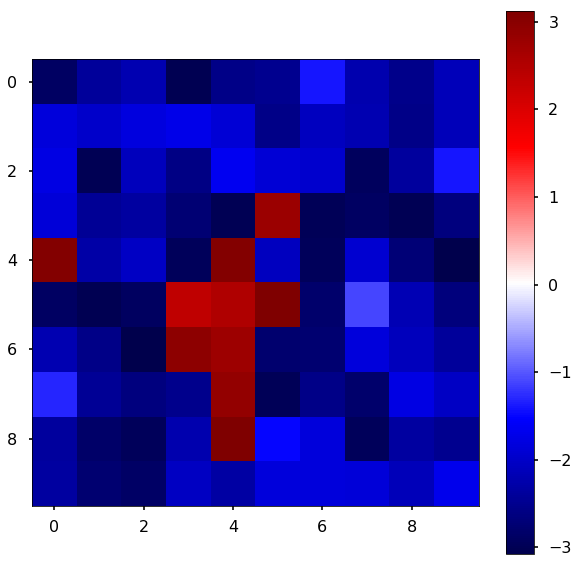

In [277]:
plt.figure(figsize=(10,10))
plt.imshow(xy.lattice, cmap=cm.seismic)
plt.colorbar()
plt.show()


# Calculate only M and E

In [115]:
from numba import jit

In [211]:
@jit(parallel=True)
def get_parameters(L, min_T=0.1, max_T=2.5, step_T=25, ESTEP=1000, STEP=2000):
    """L - lattice size"""
    T_range = np.linspace(min_T, max_T, step_T)
    E_list = []
    M_list = [x
    for T in log_progress(T_range):
        xy = XYmodel(lattice_size=L, T=T)
        E = 0
        M = 0
        # get the thermal equilibrium 
        for _ in range(ESTEP):
            xy.step()
        for _ in range(STEP):
            xy.step()
            E += xy.calculate_E()
            M += xy.calculate_M()
            
        E_list.append(E / STEP)
        M_list.append(M / STEP)
    
    return E_list, M_list

In [212]:
# For L = 8
E_8, M_8 = get_parameters(L=8)

In [279]:
# For L = 16
E_16, M_16 = get_parameters(L=16)

In [280]:
# For L = 32 
E_32, M_32 = get_parameters(L=32)

KeyboardInterrupt: 

In [ ]:
# For L = 100
E_64, M_64 = get_parameters(L=64)

In [128]:
# Save all list after evaluation !
# np.save('E_10.npy', E_10)

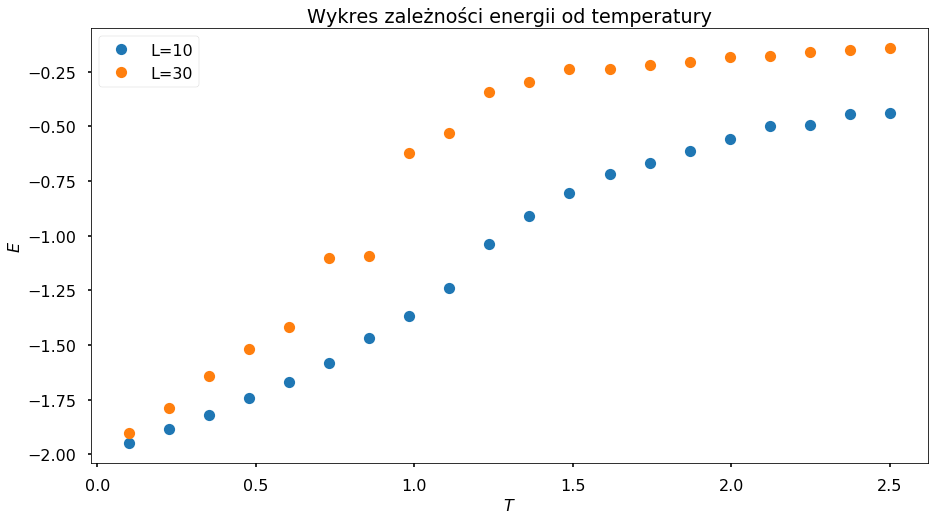

In [283]:
min_T = 0.1
max_T = 2.5
step_T = 25
T_range = np.linspace(min_T, max_T, step_T)

plt.figure(figsize=(15, 8))
plt.plot(T_range, E_8, 'o', label='L=8')
plt.plot(T_range, E_16, 'o', label='L=16')
# plt.plot(T_range, E_32, 'o', label='L=32')
# plt.plot(T_range, E_64, 'o', label='L=64')

plt.xlabel("$T$", fontsize=16)
plt.ylabel("$E$", fontsize=16)
plt.title("Wykres zależności energii od temperatury")
plt.legend(loc='upper left')
# plt.savefig("Energia.svg", dpi=800, bbox_inches='tight', format="svg")
plt.show()

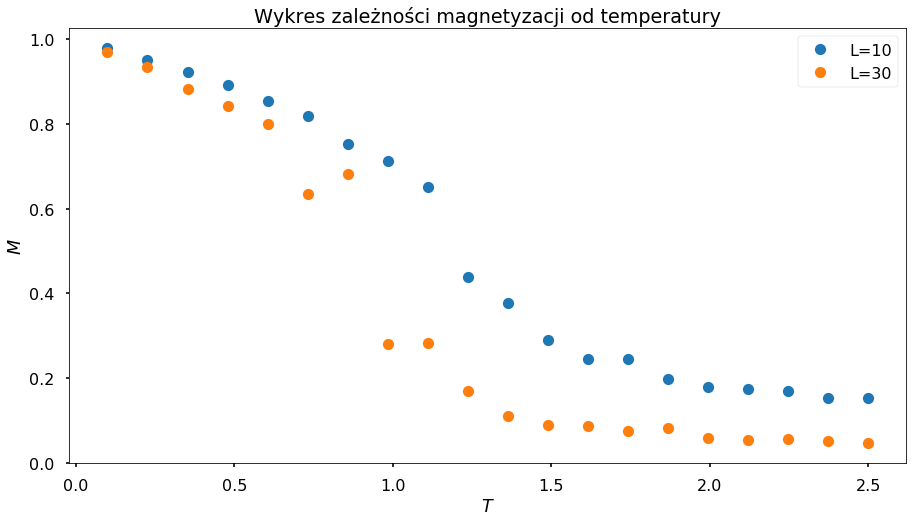

In [282]:
plt.figure(figsize=(15, 8))
plt.plot(T_range, M_8, 'o', label='L=8')
plt.plot(T_range, M_16, 'o', label='L=16')
# plt.plot(T_range, M_32, 'o', label='L=32')
# plt.plot(T_range, M_64, 'o', label='L=64')

plt.xlabel("$T$")
plt.ylabel("$M$")
plt.title("Wykres zależności magnetyzacji od temperatury")
plt.legend()
# plt.savefig("Magnetyzacja.svg", dpi=800, bbox_inches='tight', format="svg")
plt.show()

# After calculating all parameters 
## print `matplotlib.pyplot.quiver` before and after $T_c$ to show vortices and antivorices

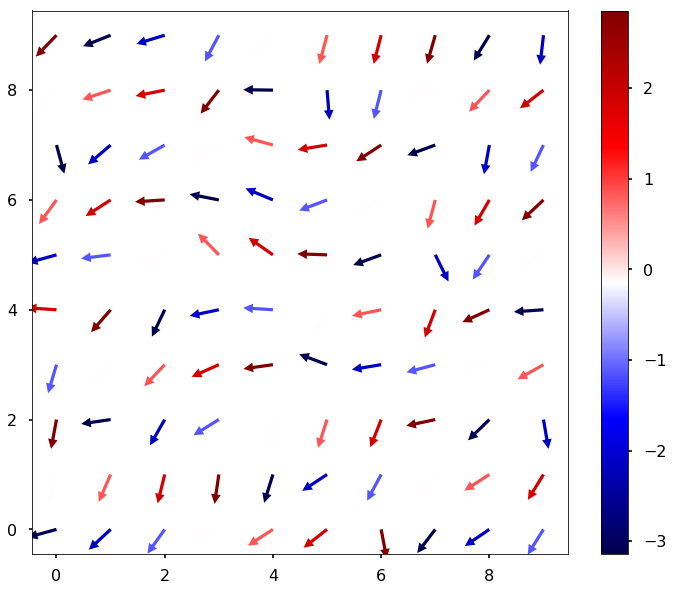

In [278]:
X, Y =  np.meshgrid(np.arange(0, xy.size, 1), np.arange(0, xy.size, 1))
U = np.cos(xy.lattice.flatten())
V = np.sin(xy.lattice.flatten())

C = np.arange(-np.pi, np.pi)

plt.figure(figsize=(12, 10))
plt.quiver(X, Y, U, V, C, headwidth=3, headaxislength=3, headlength=3, width=0.006, cmap=cm.seismic)
plt.colorbar()
plt.show()

# TODO later

### Iterate for range of temperatures
#### 1. thermal steps to get the equilibrium
#### 2. STEP and take mean of observable

In [249]:
min_T = 0.1
max_T = 2.5
T_range = np.linspace(min_T, max_T, 20)
ESTEP = 1000
STEP = 2000
L = 10
Sus_list = []

for T in log_progress(T_range):
    xy = XYmodel(L, T=T)
    Sus = 0
    # setup model
    for _ in range(ESTEP):
        xy.step()
    
    for _ in range(STEP):
        xy.step()
        Sus += xy.calculate_Sus()
    Sus_list.append(Sus / STEP)

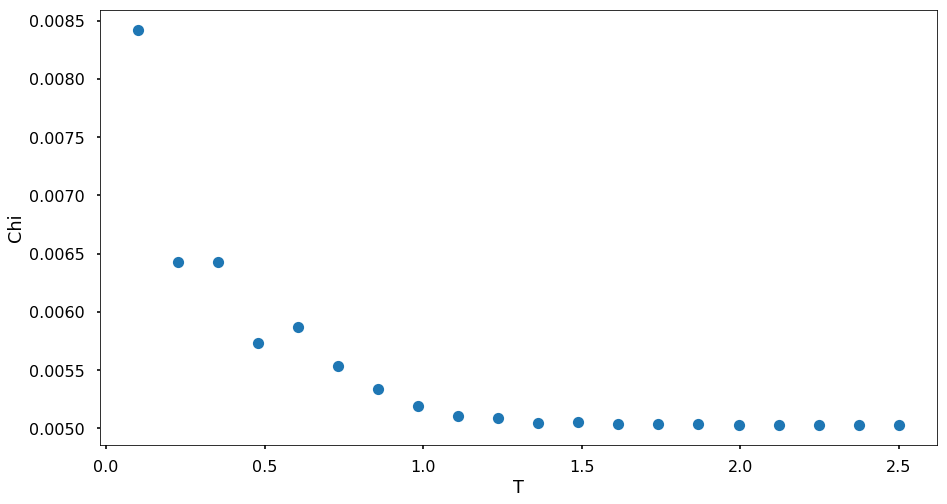

In [250]:
plt.figure(figsize=(15, 8))
plt.plot(T_range, Sus_list, 'o')
plt.xlabel("T")
plt.ylabel("Chi")
plt.show()

# Helicity modulus

In [262]:
min_T = 0.1
max_T = 2.5
T_range = np.linspace(min_T, max_T, 20)
ESTEP = 1000
STEP = 2000
L = 10
Y_list = []

for T in log_progress(T_range):
    xy = XYmodel(L, T=T)
    Y = 0
    # setup model
    for _ in range(ESTEP):
        xy.step()
    
    for _ in range(STEP):
        xy.step()
        Y += xy.calculate_Helicity()
        
    Y_list.append(Y / STEP)

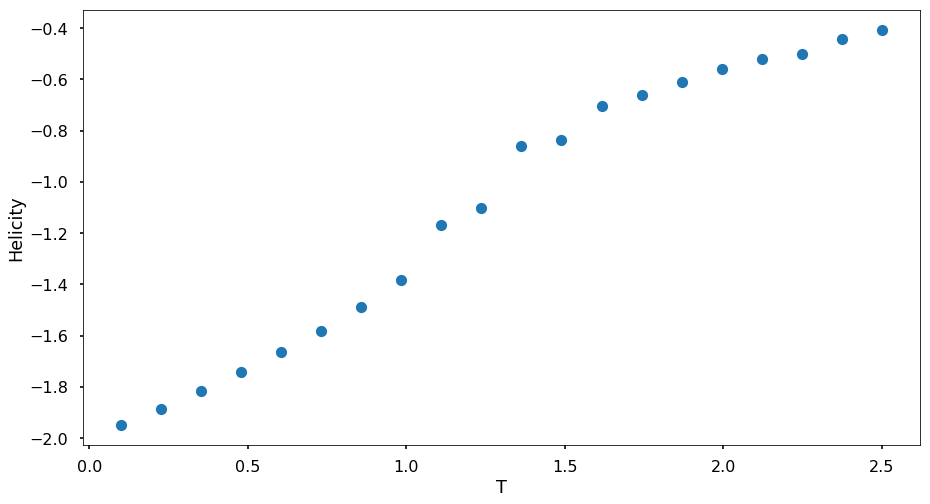

In [263]:
plt.figure(figsize=(15, 8))
plt.plot(T_range, Y_list, 'o')
plt.xlabel("T")
plt.ylabel("Helicity")
plt.show()